# Homework Assignment 3: Additional Data Prep
As in the previous data prep assignment, in this homework assignment, you will continue your exploration of the [SWAN-SF Dataset](https://doi.org/10.7910/DVN/EBCFKM), described in the paper found [here](https://doi.org/10.1038/s41597-020-0548-x).


This assignment will have you utilize the data summary table you constructed for Homework Assignment 2, as well as the partially cleaned feature dataset that was left after the completion of that assignment. 

## Step 1: Downloading the Data

This assignment will continue to only use [Partition 1](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/BMXYCB). Recall that in Homework 1, we started to construct the analytics base table for our [SWAN-SF Dataset](https://doi.org/10.7910/DVN/EBCFKM). In that assignment, we read the data from the two subdirectories, __FL__ and __NF__, of the __partition1__ direcotry. These two subdirectories represented the two classes of our target feature in the solar flare prediction problem we will be attempting to solve this semester. We then processed these samples of multivariate time series to construct descriptive features for each sample, and then placed them into our analytics base table.

Then, in Homework 2, you utilized a set of extracted descriptive features much like what you were asked to construct in Homework 1. However, this dataset contained many more extracted features than you were asked to compute for Homework 1 (>800), so we needed to explore the data to find data quality issues and identify ways to address these issues. Below are the links to the full extracted feature for all of partition 1, and a toy representative dataset, that were used as input to Homework 2.

- [Full Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/partition1ExtractedFeatures.csv)
- [Toy Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/toy_partition1ExtractedFeatures.csv)

Below you will find copies of the data for this assignment. If you didn't complete the Homework 2 assignment, or are worried your solution doesn't match the solution provided, then utilize the links below to download the data you will use for this assignment. __Note:__ Since the full dataset, and multiple copies of partially processed intermediary results, tend to take up a bit of space, you can use the toy dataset to implement and test your code. Onece you have your code working, you will then want to run with the full partition dataset to get the plots to show all the information you need. To do that, you should go to the `Kernel` dropdown and select `Restart & Run All`.  

- [Full Cleaned Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/cleaned_partition1ExtractedFeatures.csv)
- [Toy Cleaned Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/toy_cleaned_partition1ExtractedFeatures.csv)
- [Data Quality Table for Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/data_quality_table.csv)

Now that you have the partially cleaned features and data quality table csv files, you will load that data into a Pandas DataFrame using the [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method. 

In [1]:
%matplotlib inline
import os
import math
from scipy import stats
from typing import List
import pandas as pd
from pandas import DataFrame 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

### Read the dataset

In [2]:
data_dir = 'C:/Users/Hyunki/anaconda3/envs/csc4780/HW3/'
summary_table_name = 'data_quality_table.csv'
data_file = 'cleaned_partition1ExtractedFeatures.csv'

In [3]:
abt = pd.read_csv(os.path.join(data_dir, data_file))
summary_table = pd.read_csv(os.path.join(data_dir, summary_table_name))

In [4]:
summary_table

,Feature Name,Cardinality,Non-null Count,Null Count,Min,25th,Mean,50th,75th,Max,Std. Dev,Outlier Count Low,Outlier Count High
0,TOTUSJH_min,30165,73492,0,0.000000,29.756125,396.697968,110.011893,418.614528,5680.232811,694.293786,0,9014
1,TOTUSJH_max,24142,73492,0,0.783099,53.117112,492.649021,162.797367,541.875882,6078.237599,801.078303,0,8540
2,TOTUSJH_median,62001,73492,0,0.000000,40.726671,439.417610,133.981693,472.710291,5895.663839,741.152887,0,8799
3,TOTUSJH_mean,73492,73492,0,0.100756,40.833189,440.333385,134.524140,474.257514,5877.701432,741.767409,0,8783
4,TOTUSJH_stddev,73492,73492,0,0.176471,4.926721,25.019193,11.410790,30.408330,618.834925,35.130481,0,6684
...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,R_VALUE_last_value,33137,73492,0,0.000000,0.000000,1.600113,0.000000,3.551178,5.639195,1.871178,0,0
797,R_VALUE_slope_of_longest_mono_increase,9737,73492,0,0.000000,0.000000,0.350400,0.049212,0.752320,1.734700,0.494607,0,0
798,R_VALUE_slope_of_longest_mono_decrease,10383,73492,0,-1.609386,-0.004141,-0.051591,-0.000851,0.000000,0.000000,0.195380,10650,0
799,R_VALUE_avg_mono_increase_slope,40605,73492,0,0.000000,0.000000,0.155246,0.020343,0.202260,1.636702,0.266666,0,8287


### Q1 (10 points)
Let's start trying to identify features in our dataset that may be good candidates for scaling. We might want to do this with features that have a large range between the Minimum and Maximum feature value. We should also be concerned with features thta have a large number of outliers, as we may wish to treat them differently than features with a large range but just a few outliers. This is because it may be the case that the feature with a large range and large number of outliers has a bimodal or multi-modal distribution where one mode dominates the population (not uncommon with highly imbalanced data). It could also be the case that our data follows an exponental disribution (not uncommon with natrual phenomena).   

So, to begin our investigation, construct a function that takes in the Data Quality/Summary table, and returns the list of features that have a range between the Minimum and Maximum of more than 10,000, and also has more than 10% of the feature values as outliers.

After you complete the function, call it and maybe look over some of the features listed. We will be investigating a small number of them further in the next questions. 

In [5]:
def get_features_with_large_range(summary_table:DataFrame) -> List[str]:
     # Complete this function to answer the question.
        return summary_table.loc[((summary_table["Max"] - summary_table["Min"]) > 10000) & ((summary_table["Outlier Count High"] + summary_table["Outlier Count Low"]) > 0.1 * (summary_table["Non-null Count"] + summary_table["Null Count"])), "Feature Name"].tolist()

In [6]:
# Call the get_features_with_large_range function here
get_features_with_large_range(summary_table)

['TOTUSJH_var',
 'TOTUSJH_difference_of_vars',
 'TOTBSQ_min',
 'TOTBSQ_max',
 'TOTBSQ_median',
 'TOTBSQ_mean',
 'TOTBSQ_var',
 'TOTBSQ_mean_local_maxima_value',
 'TOTBSQ_mean_local_minima_value',
 'TOTBSQ_difference_of_mins',
 'TOTBSQ_difference_of_maxs',
 'TOTBSQ_difference_of_means',
 'TOTBSQ_difference_of_stds',
 'TOTBSQ_difference_of_vars',
 'TOTBSQ_difference_of_medians',
 'TOTBSQ_dderivative_mean',
 'TOTBSQ_gderivative_mean',
 'TOTBSQ_linear_weighted_average',
 'TOTBSQ_quadratic_weighted_average',
 'TOTBSQ_last_value',
 'TOTBSQ_slope_of_longest_mono_decrease',
 'TOTPOT_min',
 'TOTPOT_max',
 'TOTPOT_median',
 'TOTPOT_mean',
 'TOTPOT_stddev',
 'TOTPOT_var',
 'TOTPOT_mean_local_maxima_value',
 'TOTPOT_mean_local_minima_value',
 'TOTPOT_difference_of_mins',
 'TOTPOT_difference_of_maxs',
 'TOTPOT_difference_of_means',
 'TOTPOT_difference_of_stds',
 'TOTPOT_difference_of_vars',
 'TOTPOT_difference_of_medians',
 'TOTPOT_dderivative_mean',
 'TOTPOT_gderivative_mean',
 'TOTPOT_linear_weig

### Q2 (5 points)
Now that you have a list of the features that have a large range and a large number of outliers, lets investigate a few and see how they relate to one another, and how their distributions look.  If we see that they follow a normal distribution, then perhaps we would want to utilize Z-Score scaling. If they have an exponential distribution, then perhaps we might want to use log scaling Z-score scaling or range normalization. Also, if we find that the outliers are not part of a bimodal/multi-modal distribution, maybe we will wish to perform some outlier processing strategy like clipping before we consider what scaling/normalization method to apply.

So, for this question, use the matplotlib [subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) function. It returns a tuple of [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) and [Axes](https://matplotlib.org/stable/api/axes_api.html#matplotlib.axes.Axes) objects, so assign them to two variables that will be used to plot a set of figures. You need to request a 3 row by 1 column subplot grid to plot the three features `USFLUX_var`, `TOTUSJH_var`, and `TOTFZ_var`. You should also make the figsize different than default to make sure you can see the subfigures properly.  So, add `figsize=(8,21)` as one of the arguments to the function call as well. 

Once that is done, you can use the DataFrame [hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html) method to plot a 20 bin histogram on your Axes object returned from your subplots call described above. This means you will pass the Axes object into this method call.

In [7]:
features_to_look_at = ['USFLUX_var','TOTUSJH_var','TOTFZ_var']

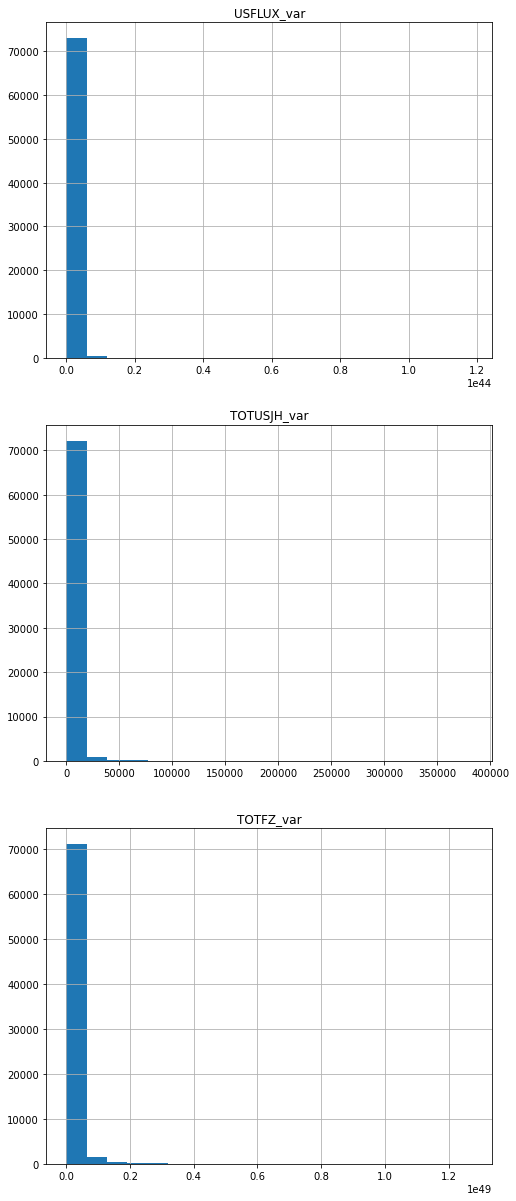

In [8]:
# Plot the features here

fig, tuple_ax = plt.subplots(3, 1, figsize=(8,21))
for idx, feature in enumerate(features_to_look_at):
    abt[feature].hist(bins=20, ax=tuple_ax[idx])
    tuple_ax[idx].set_title(feature)

### Q3 (10 points)
If you got your histogram plots to work for Q2 above, you would see that each of these features are highly right skewed, almost exponential like distribution. So, we know the outliers ar not part of a bimodal or multi-modal distribution. If you recall from lecture one of the simplest methods to handle outliers would be to clamp them to some threshold value. So, let's see what the distributions look like if we clamp the high outliers to some value, like the threshold for being classified as an outlier on the high end namely $Q3+1.5IQR$.

So, for this question, construct a function that performs clamping of the high outliers and places the results in a new output DataFrame since we want to preserve the origianl values for now. The names of the features in the output DataFrame should have an additional `_clamp` appended to the original feature name. The high outliers should be clamped to the threshold value that we used to classify them as an outlier $val > Q3+1.5IQR$. Once you have done this, replot the the three features `USFLUX_var`, `TOTUSJH_var`, and `TOTFZ_var` that were plotted for Q2 after you have applied this funciton on them.

In [9]:
import copy
def clamp_to_third_quartile(data:DataFrame) -> DataFrame:
    # Complete this function to answer the question.
    
    df_return = pd.DataFrame()
    for feature_name in data.columns:
        df_feature = copy.deepcopy(data[feature_name])
        percentile25 = np.percentile(df_feature, 25)
        percentile75 = np.percentile(df_feature, 75)
        IQR = percentile75 - percentile25
        bound_high = percentile75 + 1.5 * IQR
        df_feature[df_feature > bound_high] = bound_high
        df_return[feature_name + "_clamp"] = df_feature
        
    return df_return

In [10]:
# Call the clamp_to_third_quartile function here
abt_clamp = clamp_to_third_quartile(abt[features_to_look_at])

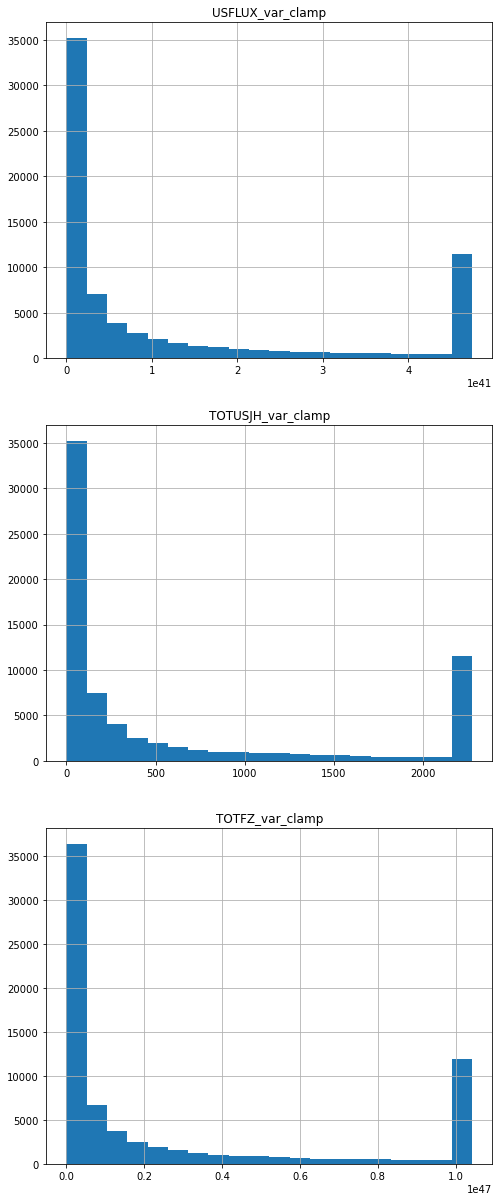

In [11]:
# Replot the features here
fig, tuple_ax = plt.subplots(3, 1, figsize=(8,21))
for idx, feature in enumerate(features_to_look_at):
    abt_clamp[feature + "_clamp"].hist(bins=20, ax=tuple_ax[idx])
    tuple_ax[idx].set_title(feature + "_clamp")

### Q4 (5 points)
Now that we have handled the outliers in these three features, the distributions look a bit different. You can now definitely see that the values follow an exponental distribution, at least up to the threshold we clamped the outliers to. These outliers being clamped to an upper threshold may or may not be helpful for our final classification task. If all of the outlier values happen to be one class, or could be split to one class based on a combination of two features, then we might like to keep them calamped like this. However, if we see that there are now multiple different classes all bunched together, we might wisht to try a different method of handling outliers. 

Let's investigate further by plotting a Scatter Plot Matrix (pair plot) of these features. To accomplish this, use the seaborn [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function. You should also add the labels to your DataFrame before passing it to the function. To add the labels (recall they are called `lab` in the original dataset in the ABT), use the DataFrame [join](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) method to join a DataFrame containing the labels and your DataFrame containing the partially processed features from Q3. When calling the pairplot method, you will then use the `hue='lab'` argument to tell it to plot each label as different color, so we can see how the different classes are distributed.  Additionally, you should use the `diag_kind='hist'` argument to specify that the diagonal subplots are histogram plots. 

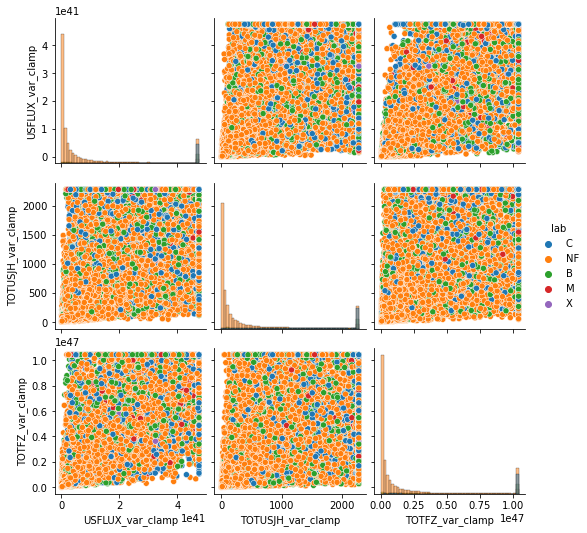

In [12]:
# Plot the features here
sns.pairplot(abt_clamp.join(abt["lab"]), hue="lab", diag_kind="hist")

### Q5 (10 points)
If, in the previous question, you were to plot the three features using the entire partition, you would see that the combination of `USFLUX_var` and `TOTFZ_var` seem to push most of the `M` and `X` class flares to the upper right hand corner of the pair plot whereas the use of `TOTUSJH_var` doesn't make this as obvious when paired with either of the other two features.  To be honest, no combination of these these features seem to be doing a great job at providing a good way to separate the classes.  We see that the clamped values are full of several different classes, so maybe we should try a different method for our scaling and handling outliers.

If you recall from lecture, a good method to scale an exponential distribution that we see here is to perform a log scaling on them. So, for this question, let's apply a log base 10 scaling to each value of the features. You can use the [numpy.log10](https://numpy.org/doc/stable/reference/generated/numpy.log10.html) function for this, but remember, we cannot apply log to negative or zero value numbers.  So, you will need to shift the values of the feature by the minimum value (plus a small offset to keep from having zero values) to handle this fact.  

This function should also return a new DataFrame with the processed values. The features in the new output DataFrame names should have an additional `_log10` appended to the original feature name. Once you have done this, replot the histogram of the three features `USFLUX_var`, `TOTUSJH_var`, and `TOTFZ_var` that were plotted for Q2 after you have applied this funciton on them. You should then follow this up by plotting the the seaborn [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function on these same features, just as you did in Q4 but this time on the log scaled features. 


In [13]:
def apply_log_scale(data:DataFrame) -> DataFrame:
     # Complete this function to answer the question.
        
     df_return = pd.DataFrame()
     for feature_name in data.columns:
          df_feature = copy.deepcopy(data[feature_name])
          df_feature = df_feature + np.min(df_feature) + 1e-9
          df_feature = np.log10(df_feature)
          df_return[feature_name + "_log10"] = df_feature

     return df_return

In [14]:
# Call the apply_log_scale function here
abt_log = apply_log_scale(abt[features_to_look_at])

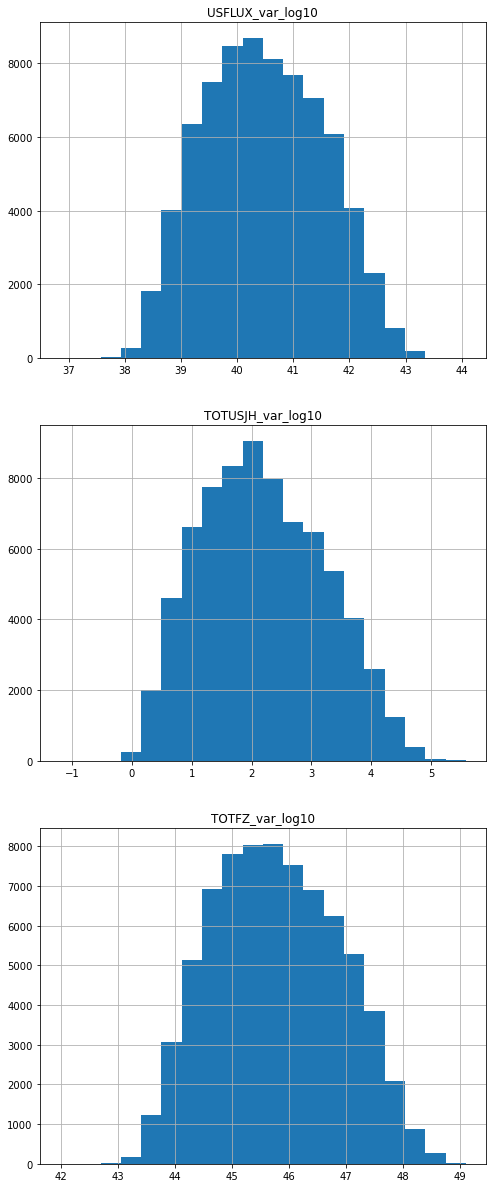

In [15]:
# Replot the histograms of the features here
fig, tuple_ax = plt.subplots(3, 1, figsize=(8,21))
for idx, feature in enumerate(features_to_look_at):
    abt_log[feature + "_log10"].hist(bins=20, ax=tuple_ax[idx])
    tuple_ax[idx].set_title(feature + "_log10")

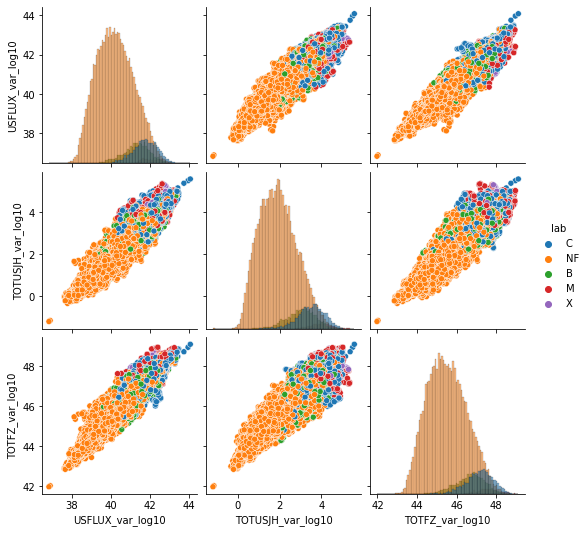

In [16]:
# Replot the pair plots here
sns.pairplot(abt_log.join(abt["lab"]), hue="lab", diag_kind="hist")

### Q6 (10 points)
If you wer to plot the three features using the entire partition, you will now see that a combination of any two of the three features `USFLUX_var`, `TOTUSJH_var`, and `TOTFZ_var` do a rather good job at seperating the `NF` class from from the `C`, `M`, and `X` class observations.  So, let's assume that these are a good first set of features to use and get them ready for use in our models.  

For this question, let's start to construct our dataset of cleaned, scaled, and normalized feature values.  Since we decided that `USFLUX_var`, `TOTUSJH_var`, and `TOTFZ_var` are candidates for use later, let's process them further to make them ready to be placed in our machine learning algorithms.  To do this, you shall construct a function to process individual features by name.  

First, construct a function that takes in the entire analytics base table of raw feature values and a feature name (I've started the function below). 

 * The function should return the log base 10 scaled feature as a DataFrame. 
 * You should make sure to copy the values from the ABT before processing so as not to change the values of the ABT. 
 * You will need to handle negative and zero valued features correctly by adding an offset prior to applying the log scale. In this case, use the minimum value of the feature plus `0.01` for only those features that meet this criteria. 
 * Any values that are not a number should be assigned the offset value prior to log scaling.
 * In addition to the log scaling, you should apply a range scaling to the log scaled feature values to make the featur values fall between `0` and `1`.  

You should then call this function for each of the three features `USFLUX_var`, `TOTUSJH_var`, and `TOTFZ_var`, each time passing in the analytics base table. You will then join the returned feature sets to construct the start of our cleaned feature table (keep this around for later you will be adding to it). Additionally, make sure the class labels are joined to your resultant DataFrame.

Finally, you should then follow this up by plotting the the seaborn [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function on these same features to verify your function and join have worked correctly. When calling the pairplot method, you will use `hue='lab'` argument to tell it to plot each label as different color, so we can see how the different classes are distributed.  Additionally, you should use the `diag_kind='hist'` to specify that the diagonal subplots are histogram plots. 

In [17]:
def log_and_range_scale(data:DataFrame, feature_name:str) -> DataFrame:
    # Complete this function to answer the question.
    df_feature = copy.deepcopy(data[feature_name])
    df_feature = df_feature + np.min(df_feature) + 0.01
    df_feature.fillna(np.min(df_feature) + 0.01)
    df_feature = np.log10(df_feature)
    # range scaling
    df_feature = (df_feature - np.min(df_feature))/ (np.max(df_feature) - np.min(df_feature))

    return df_feature

In [18]:
# Construct your inital result dataframe here by calling the log_and_range_scale function
abt_log_range = pd.DataFrame()
for feature_name in features_to_look_at:
    abt_log_range[feature_name] = log_and_range_scale(abt, feature_name)
abt_log_range = abt_log_range.join(abt["lab"])

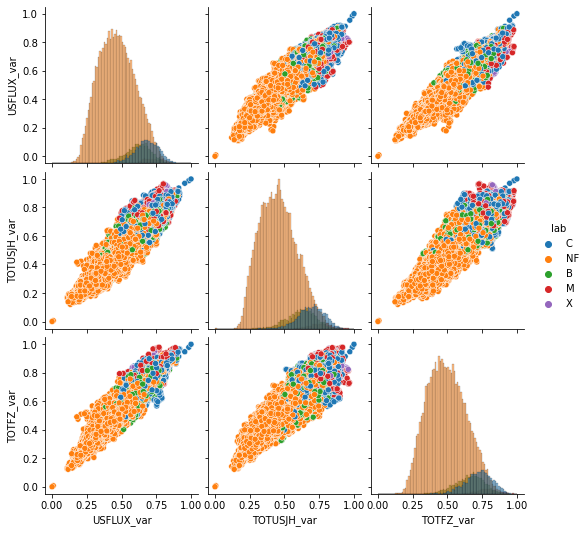

In [19]:
# Replot the pair plot here to verify your result
sns.pairplot(abt_log_range, hue="lab", diag_kind="hist")

### Q7 (5 points)
Let's start trying to identify features in our dataset that may be good candidates for Z-Score normalization. We might want to do this with features that are the opposite of the ones we found for Q1, namely ones that don't have a large number of outliers.

So, to begin our investigation, construct a function like was done for Q1, one that takes in the Data Quality/Summary table, and returns the list of features that meet our criteria. For this question, we wish to to list those that have a range between the Minimum and Maximum of less than 10,000, and also have less than 5% of the feature values as outliers.

Once you complete the function, call it and maybe investigate the list of features.  We will work with a small number in the next questions.

In [20]:
def get_features_with_smaller_range(summary_table:DataFrame) -> List[str]:
    # Complete this function to answer the question.
    return summary_table.loc[((summary_table["Max"] - summary_table["Min"]) < 10000) & ((summary_table["Outlier Count High"] + summary_table["Outlier Count Low"]) < 0.05 * (summary_table["Non-null Count"] + summary_table["Null Count"])), "Feature Name"].tolist()

In [21]:
# Call the get_features_with_smaller_range function here
list_features_with_smaller_range = get_features_with_smaller_range(summary_table)
list_features_with_smaller_range

['TOTUSJH_skewness',
 'TOTUSJH_dderivative_skewness',
 'TOTUSJH_gderivative_skewness',
 'TOTBSQ_skewness',
 'TOTBSQ_gderivative_skewness',
 'TOTPOT_skewness',
 'TOTPOT_dderivative_skewness',
 'TOTPOT_gderivative_skewness',
 'TOTUSJZ_skewness',
 'TOTUSJZ_dderivative_skewness',
 'TOTUSJZ_gderivative_skewness',
 'ABSNJZH_skewness',
 'ABSNJZH_kurtosis',
 'ABSNJZH_dderivative_skewness',
 'ABSNJZH_gderivative_skewness',
 'SAVNCPP_skewness',
 'SAVNCPP_dderivative_skewness',
 'SAVNCPP_gderivative_skewness',
 'SAVNCPP_dderivative_kurtosis',
 'USFLUX_skewness',
 'USFLUX_dderivative_skewness',
 'USFLUX_gderivative_skewness',
 'TOTFZ_skewness',
 'TOTFZ_kurtosis',
 'TOTFZ_gderivative_skewness',
 'MEANPOT_skewness',
 'MEANPOT_kurtosis',
 'MEANPOT_dderivative_skewness',
 'EPSZ_min',
 'EPSZ_max',
 'EPSZ_median',
 'EPSZ_mean',
 'EPSZ_skewness',
 'EPSZ_mean_local_maxima_value',
 'EPSZ_mean_local_minima_value',
 'EPSZ_difference_of_mins',
 'EPSZ_difference_of_means',
 'EPSZ_difference_of_medians',
 'EPSZ

### Q8 (5 points)
Now that you have a list of the features that have a smaller range and a smaller number of outliers, lets investigate a few and see how they relate to one another, and how their distributions look.  If we see that they follow a normal distribution, then perhaps this is a good indication that we would want to utilize Z-Score normalization.  We will still want to handle outliers, but hopefully this won't be as much of an issue as they were with other data we processed in earlier questions.

So, like you did for Q2, use the matplotlib [subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) function to get the Figure and Axes object used to plot a set of figures. You need to request a 3 row by 1 column subplot grid to plot the three features listed below. You should also make the figsize different than default to make sure you can see the subfigures.  So, add `figsize=(8,21)` as one of the arguments to the function call as well. 

Once that is done, you can use the DataFrame [hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html) method to plot a 20 bin histogram on your Axes object returned from your subplots call described above. This means you will pass the Axes object into this method call. Plot the features `R_VALUE_median`, `MEANGBT_median`, and `TOTUSJH_skewness` to view how they are distributed.

In [22]:
small_outlier_features = ['R_VALUE_median', 'MEANGBT_median', 'TOTUSJH_skewness']

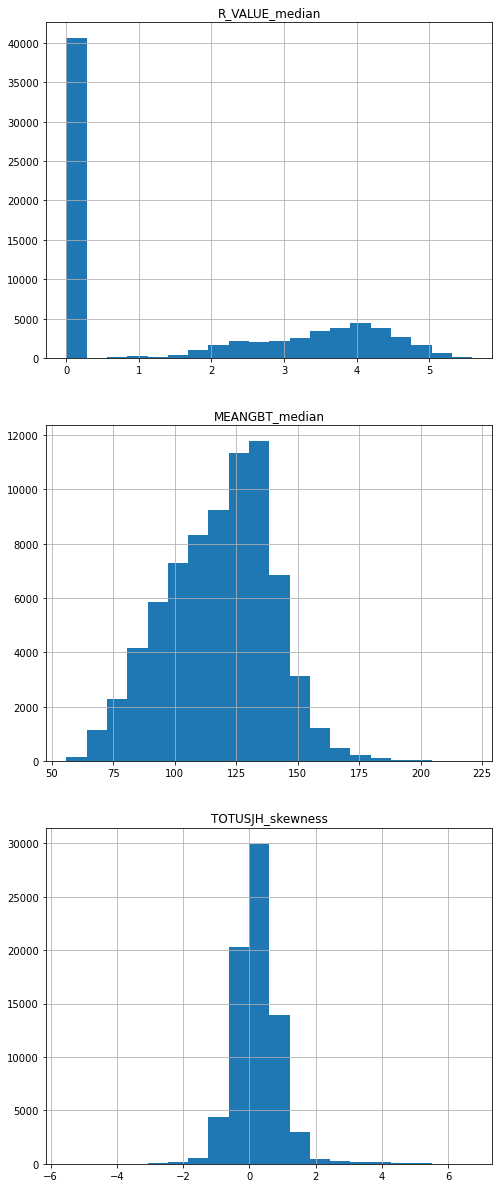

In [23]:
# Plot the histograms of the given features here
fig, tuple_ax = plt.subplots(3, 1, figsize=(8,21))
for idx, feature in enumerate(small_outlier_features):
    abt[feature].hist(bins=20, ax=tuple_ax[idx])
    tuple_ax[idx].set_title(feature)

### Q9 (5 points)
If you got yor histogram plots to work above using the full partition dataset, you would see `MEANGBT_median` and `TOTUSJH_skewness` have distributions that look to be similar to a normal distribution.  So, these are probably good candidates for Z-Score normalization. On the other hand, `R_VALUE_median` is more of a bimodal distribution with a large number zero values, and a second more normal looking distribution.  So, this one is probably not a good candidate for Z-Score, and we will simply use range normalization on this feature. 

It may not be possible/cost efficient for us to continue plotting features to check all their distributions. So, we need a more systematic way of testing for normality in the distributions. Lucky for us, we already coverd such a test in lecture so we know that we can use the Jarque-Bera goodness of fit test to test if the sample data has the skewness and kurtosis matching a normal distribution. 

So, for this question, you will construct a function that performs this test on a list of features (I've started the function below). The features we wish to test on are those found in Q7 to have a smaller range and a lower number of outliers than the data we were applying the log scaling method to. This function should do the following:

 * Take in our analytics base table and a list of features from that table to perform the test on.
 * Return a list of features that have a p-value from the Jarque-Bera goodness of fit test that is greater than `0.001`. The function in scipy can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html).
 
Recall that having a p-value of `0.001` means we can reject the null hypothesis ($H_0$) that the data is normally distributed, with 99.9% certainty.  With values greater than this, we have less certainty that the data is not normaly distributed, and values less than this indicate greater certainty of the non-normality of the data.  

In [24]:
def filter_normal_features(data:DataFrame, feature_names:List[str])-> List[str]:
    #Complete this function to answer the question.
    list_return = []
    for feature_name in feature_names:
        if stats.jarque_bera(data[feature_name]).pvalue > 0.001: list_return.append(feature_name)
    
    return list_return

In [25]:
# Call the filter_normal_features function here
filter_normal_features(abt, list_features_with_smaller_range)

[]

### Q10 (5 points)
If you checked the results from Q9 on the full dataset, you will find that we were unable to find any feature distributions where we could not reject the null hypothesis. This follows from the number of samples we have (`n>73,000`) giving plenty of data to test our hypothesis on. It would be expected for our data to much more closely follow a normal distribution by the time we have that many samples than they are, so we will need a different way to filter which distributions will wish to use Z-Score standardization on.  

First, lets construct a function that takes in the entire analytics base table of raw feature values and a feature name (I've started the function below). We will be using this function in our method for finding odd distributions, so we might as well construct it now. It shall do the following:

 * Return the Z-Score normalized feature requested by the input name as a DataFrame. 
 * It should apply Z-Score normalizaiton to a copy of the feature from the raw feature values table using the $a_{i}' = \frac{a_{i}-\hat{a}}{sd(a)}$ where $\hat{a}$ is the mean of the feature and $sd(a)$ is the standard deviation of the feature. 

Next, call this function twice by passing in the analytics base table, and the each of the feature names `MEANGBT_median` and `TOTUSJH_skewness`. Then join the two returned feature sets to the cleaned feature table from Q6. Additionally, you will also need to join the `R_VALUE_median` to the cleaned feature table from Q6. 

Finally, you should then follow this up by plotting the the seaborn [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function on these same features to verify your function and join have worked correctly. When calling the pairplot method, you will use `hue='lab'` argument to tell it to plot each label as different color, so we can see how the different classes are distributed.  Additionally, you should use the `diag_kind='hist'` to specify that the diagonal subplots are histogram plots. 

In [26]:
def do_z_score_normalization(data:DataFrame, feature_name:str) -> DataFrame:
    #Complete this function to answer the question.
    df_feature = copy.deepcopy(data[feature_name])
    mean_value = np.mean(df_feature)
    std_value = np.std(df_feature)
    df_feature = (df_feature - mean_value) / std_value

    return df_feature

In [27]:
# Call the do_z_score_normalization function for the specified features here
abt_log_range["MEANGBT_median"] = do_z_score_normalization(abt, "MEANGBT_median")
abt_log_range["TOTUSJH_skewness"] = do_z_score_normalization(abt, "TOTUSJH_skewness")
abt_log_range["R_VALUE_median"] = copy.deepcopy(abt["R_VALUE_median"])

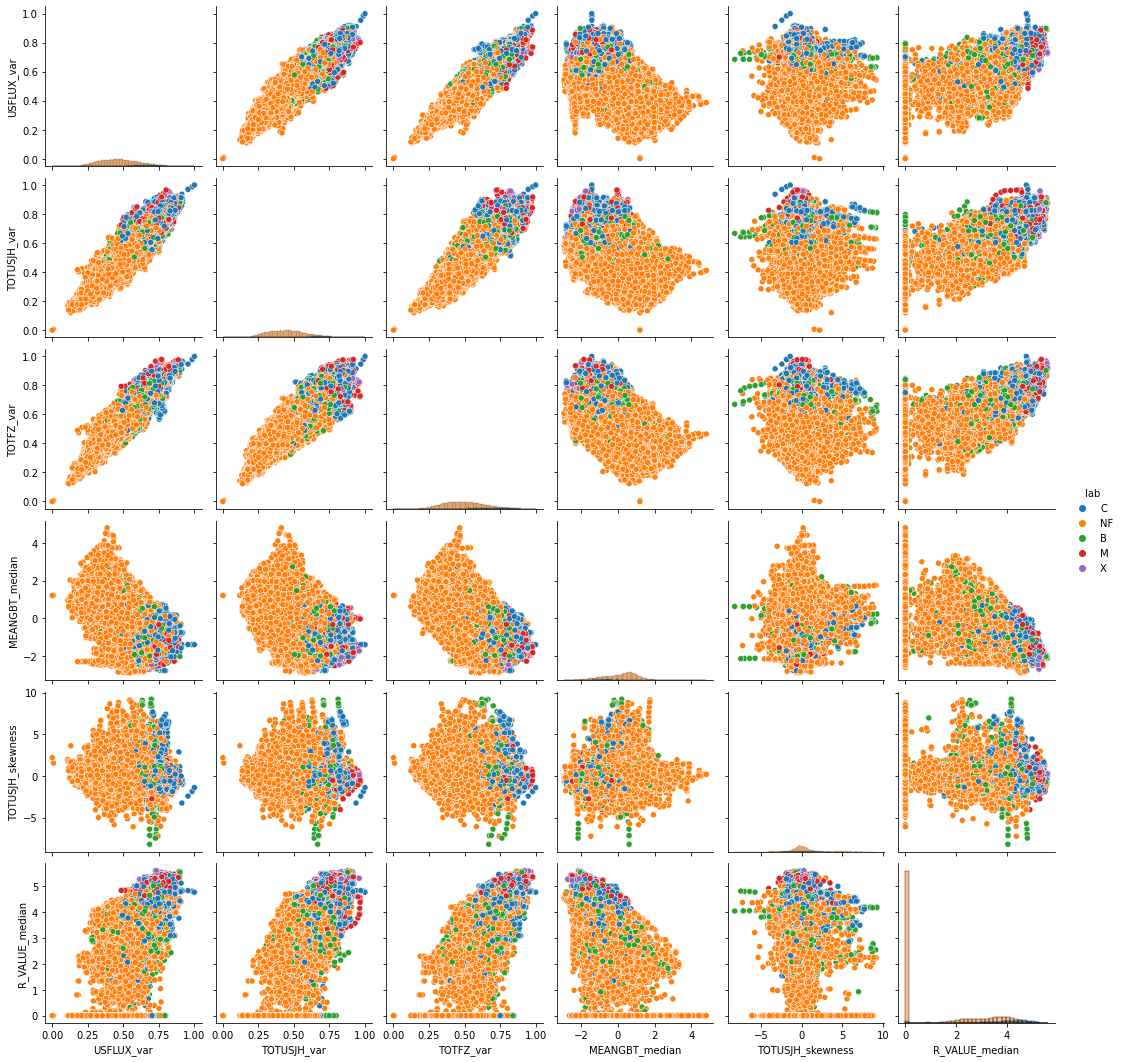

In [28]:
# Add the features to the previous result ABT and plot the pair plot here
sns.pairplot(abt_log_range, hue="lab", diag_kind="hist")

### Q11 (10 points)
Now let's see if we can find a method to identify features with abnormal distributions. In this function, we will be utilizing the Student's t continuous random variable generator percent point function (ppf) from [scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html).  This function takes a percentage value or list of values. The percentage is used to calculate the corresponding threshold where the given percentage of the distribution will be less than the critical value returned if the distribution follows the T distribution with the given degrees of freedom. Since we want to come close to a normal distribution but not quite the same, we will call this function with `df=5`, as we can see [here](https://en.wikipedia.org/wiki/Student%27s_t-distribution) that using 5 degrees of freedom is a close approximation.  

So, for this function we will be construting an error function that tests how well the tails of the given data matches the T distribution with 5 degrees of freedom (I have started it below). This function should do the following:

 * Calculate the cirtical values for `1%`, `5%`, `10%`, `90%`, `95%`, and `99%` using stats.t.ppf([0.01, 0.05, 0.10, 0.90, 0.95, 0.99], 5)
 * Use the do_z_score_normalization function from previously to get the Z-Score standardized data, this way it has a mean of 0 and standard deviation of 1, which the values calculated above expect.
 * Use the values from the first two steps to calculate the percentage of values that fall between each of the critical values and the tail of the distribution they are closest to. For example the `1%` is closest to the negative extreme of the distribution so you would calculate how many values in the distribution are less than that value (Same for `5%` and `10%`). Similarly, you would do this for the `99%` but counting those in the dataset that are higher.
 * Using the percentages from above, you will calculate the sum of absolute error between the expected percentage and the actual percentage for the left tail.
 * You will then calculate the sum of the absolute error between the expected percentage and the actual percentage for the right tail.
 * Finally, you will find the absolute difference between the error on the left and the error on the right.  This will be the value you return.
 
Once you have completed this, try calling the method on the `R_VALUE_median`, `MEANGBT_median`, and `TOTUSJH_skewness` to see how this metric performs on each of the features. 

In [29]:
def t_error(data:DataFrame, feature_name:str)-> float:
    #Complete this function to answer the question.
    sum_lefttail, sum_righttail = 0.0, 0.0
    df_feature = do_z_score_normalization(data, feature_name)
    total_count = df_feature.shape[0]
    list_percent_value = [0.01, 0.05, 0.10, 0.90, 0.95, 0.99]
    for percent_value, crit_value in zip(list_percent_value, stats.t.ppf(list_percent_value, 5)):
        if percent_value < 0.5: sum_lefttail += abs((df_feature[df_feature < crit_value].count() / total_count) - percent_value) * 100
        else: sum_righttail += abs((df_feature[df_feature > crit_value].count() / total_count) - (1 - percent_value)) * 100
    return abs(sum_lefttail - sum_righttail)

In [30]:
# Call the t_error function here with various features and compare the results
for feature_name in ["R_VALUE_median", "MEANGBT_median", "TOTUSJH_skewness"]:
    print(feature_name + " t error: ", t_error(abt, feature_name))

R_VALUE_median t error:  9.377891471180533
MEANGBT_median t error:  4.6807815816687555
TOTUSJH_skewness t error:  2.2968486365862955


### Q12 (5 points)
Now let's go ahead and construct a function that iterates over the `smaller_range_features` we found in Q7 and filters them to only include those that have a `t_error` of `5` or less. 

This function should take in the full ABT and the list of features produced in Q7 and return the feature names that meet the above criteria.

In [31]:
def filter_by_t_err(data:DataFrame, feature_names:List[str])->List[str]:
    #Complete this function to answer the question.
    list_return = []
    for feature_name in feature_names:
        if t_error(data, feature_name) <= 5: list_return.append(feature_name)

    return list_return

In [32]:
# Call the flter_by_t_err function here.
list_filter_by_t_err = filter_by_t_err(abt, list_features_with_smaller_range)

### Q13 (5 points)
For this function, you will again construct a function that takes in the entire analytics base table of raw feature values and a feature name (I've started the function below). This function should then do the followting:

 * Make a copy of the values in the ABT for the feature name provided.
 * Apply an offset to each value to make all the values within the sequence strictly positive. This only applys if some of the values are negative. 
 * If you find values with a NAN, then assign them a zero value. 
 * Apply the square root to each of the values after they have been made to be positive.
 * In addition to the square root scaling, you should apply a range scaling to the log scaled feature values to make the featur values fall between `0` and `1`.  
  * Return a dataframe with the transformed feature values and the header name.


In [33]:
def sqrt_and_range_scale(data:DataFrame, feature_name:str) -> DataFrame:
    #Complete this function to answer the question.
    df_feature = copy.deepcopy(data[feature_name])
    df_feature = np.sqrt(df_feature)
    df_feature.fillna(0)
    df_feature = (df_feature - np.min(df_feature))/ (np.max(df_feature) - np.min(df_feature))
    
    return df_feature

In [34]:
# Call the sqrt_and_range_scale function here with some feature name as input
sqrt_and_range_scale(abt, "R_VALUE_median")

0        0.892290
1        0.000000
2        0.843490
3        0.000000
4        0.000000
           ...   
73487    0.528321
73488    0.000000
73489    0.000000
73490    0.000000
73491    0.000000
Name: R_VALUE_median, Length: 73492, dtype: float64

### Q14 (10 points)
Now you will bring it all together, using the functions you have already constructed. This function should take in the entire analytics base table of raw feature values and the summary table, then perform a transormation on all the values in the table ABT.  The function should do the following:

 * Determine which features have a large range and large number of outliers (use your function from Q1 for this) and apply the log and range scaling to these features (use your function from Q6 for this).
 * Determine which features have a smaller range and lower nuber of outliers (use your function from Q7 for this) and then filter this list to only include those that have the t_err of less than 5 (use your function for question 12 for this). 
 * Apply the the Z-score normalization to the features that passed the filtering by t_err.
 * Apply regular range scaling to the features that were identified as lower number of outliers and feature range but did not pass the t_err filter.
 * Apply square root scaling to the remaining features that have a range of of 10K or larger (use your function from Q13 for this).
 * Apply range scaling to the remaing features (this should only be those that have a large number of outliers and a range of less than 10K).  
 * Return a new ABT with all of the processed features and the labels for each entry.

In [35]:
def process_all_features(data:DataFrame, summary_table:DataFrame) -> DataFrame:
    #Complete this function to answer the question.
    list_large_range = get_features_with_large_range(summary_table)
    list_smaller_range = get_features_with_smaller_range(summary_table)
    # larger range
    for feature_name in list_large_range:
        data[feature_name] = log_and_range_scale(data, feature_name)
    # smaller range
    for feature_name in list_smaller_range:
        # Z-score normalization
        if t_error(data, feature_name) < 5: 
            data[feature_name] = do_z_score_normalization(data, feature_name)
        # regular range scaling
        else:
            data[feature_name] = (data[feature_name] - np.min(data[feature_name])) / (np.max(data[feature_name]) - np.min(data[feature_name]))
    # else
    for feature_name in summary_table["Feature Name"].tolist():
        if feature_name in list_large_range or feature_name in list_smaller_range: continue
        if (summary_table.loc[summary_table["Feature Name"] == feature_name, "Max"].values - summary_table.loc[summary_table["Feature Name"] == feature_name, "Min"].values) >= 10000:
            data[feature_name] = sqrt_and_range_scale(data, feature_name)
        else:
            data[feature_name] = (data[feature_name] - np.min(data[feature_name])) / (np.max(data[feature_name]) - np.min(data[feature_name]))
    return data

In [36]:
# Call the process_all_features function here and maybe save your results
abt_new = process_all_features(abt, summary_table)
abt_new.to_csv(data_dir + 'cleaned_partition1ExtractedFeatures2.csv')

C:\Users\Hyunki\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Hyunki\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
